# Adaptive Component Separation with K-means Clustering

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CMBSciPol/furax-compsep-paper/blob/main/notebooks/kmeans_2.ipynb)

## Learning Objectives

By the end of this notebook, you will:
- Understand adaptive sky clustering for spatially-varying spectral parameters
- Implement spherical K-means clustering for CMB component separation
- Optimize parameters within each cluster using variance-based selection
- Visualize how spatial parameter variation improves foreground modeling

## The Adaptive Clustering Approach

Traditional component separation assumes uniform spectral parameters across the entire sky. In reality, Galactic emissions vary spatially. Our approach uses spherical K-means clustering to partition the sky into regions, allowing different spectral parameters in each cluster.

**Key Innovation**: Minimize CMB reconstruction variance by adaptively clustering sky pixels and optimizing spectral parameters per cluster.

In [1]:
# Setup and Data Loading

import os

os.environ["EQX_ON_ERROR"] = "nan"
os.environ["JAX_PLATFORM_NAME"] = "cpu"

# Core libraries
# Data utilities
from functools import partial

import healpy as hp

# JAX ecosystem
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scienceplots  # noqa: F401
from furax._instruments.sky import (
    get_noise_sigma_from_instrument,
)  # FURAX framework
from furax.obs import negative_log_likelihood, sky_signal
from furax.obs.landscapes import FrequencyLandscape
from furax.obs.operators import NoiseDiagonalOperator
from furax.obs.stokes import Stokes
from jax_grid_search import ProgressBar, condition, optimize

# JAX-HEALPix for clustering and sky operations
from jax_healpy.clustering import (
    find_kmeans_clusters,
    get_cutout_from_mask,
    get_fullmap_from_cutout,
    normalize_by_first_occurrence,
)
from rich.progress import BarColumn, TimeElapsedColumn, TimeRemainingColumn

from furax_cs.data.generate_maps import get_mask, load_from_cache, save_to_cache
from furax_cs.data.instruments import get_instrument
from furax_cs.optim import lbfgs_zoom

W1205 18:05:59.972123  112273 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1205 18:05:59.978056  112177 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [2]:
# Configure JAX
jax.config.update("jax_enable_x64", True)

# Load CMB and foreground data
nside = 64
npixels = 12 * nside**2
noise_id = 0
noise_ratio = 1.0
tag = "c1d1s1"
mask_name = "GAL020"

In [3]:
# Generate and load multi-frequency data
save_to_cache(nside, sky=tag)
nu, freq_maps = load_from_cache(nside, sky=tag)
print(f"Frequency maps shape: {freq_maps.shape}")
print(f"Frequencies: {len(nu)} bands from {nu[0]:.0f} to {nu[-1]:.0f} GHz")

# Convert to FURAX format (Q,U polarization)
d = Stokes.from_stokes(Q=freq_maps[:, 1, :], U=freq_maps[:, 2, :])

# Load galactic mask (cleanest 20% of sky)
mask = get_mask(mask_name, nside=nside)
(indices,) = jnp.where(mask == 1)
coverage = jnp.mean(mask) * 100
print(f"Sky coverage: {coverage:.1f}% ({len(indices):,} pixels)")

# Extract masked data for computation
masked_d = get_cutout_from_mask(d, indices, axis=1)
print(f"Masked data shape: {masked_d.shape}")

Loaded freq_maps for nside 64 from cache with noise_ratio 0.0.
Loaded freq_maps for nside 64 from cache.
Frequency maps shape: (15, 3, 49152)
Frequencies: 15 bands from 40 to 402 GHz
Sky coverage: 19.7% (9,695 pixels)
Masked data shape: (15, 9695)


In [ ]:
# Spherical K-means Clustering

# Configure clustering parameters for different spectral indices
cluster_config = {
    "temp_dust": 10,  # Dust temperature clusters
    "beta_dust": 20,  # Dust spectral index clusters
    "beta_pl": 5,  # Synchrotron spectral index clusters
}
cluster_config = jax.tree.map(lambda x: min(indices.size, x), cluster_config)

# Generate clusters for each parameter type
print("Generating spherical K-means clusters...")
clusters = {}

# Generate spherical K-means clusters on unmasked pixels
cluster_map = jax.tree.map(
    lambda c: find_kmeans_clusters(
        mask,
        indices,
        c,
        jax.random.PRNGKey(42),  # Fixed seed for reproducibility
        max_centroids=c,
        initial_sample_size=1,
    ),
    cluster_config,
)

cluster_map = jax.tree.map(
    lambda arr, c: normalize_by_first_occurrence(arr, c, c), cluster_map, cluster_config
)

cluster_map = {f"{param}_patches": patches for param, patches in cluster_map.items()}

print("Clustering complete!")

# Visualize the clustering results
fig = plt.figure(figsize=(15, 5))

param_labels = ["Dust Temperature", "Dust Spectral Index", "Synchrotron Index"]
for i, (param, label) in enumerate(zip(cluster_config.keys(), param_labels)):
    cluster_data = cluster_map[f"{param}_patches"]
    n_unique = jnp.unique(cluster_data[cluster_data != hp.UNSEEN]).size

    hp.mollview(
        cluster_data,
        title=f"{label}\n({n_unique} clusters)",
        sub=(1, 3, i + 1),
        bgcolor=(0.0,) * 4,
    )

plt.tight_layout()
plt.show()

# Extract masked clusters for optimization
masked_clusters = get_cutout_from_mask(cluster_map, indices)
masked_clusters = jax.tree.map(lambda x: x.astype(jnp.int64), masked_clusters)
print("Masked clusters ready for optimization")

Generating spherical K-means clusters...


In [ ]:
noise_id = 0
noise_ratio = 1.0

instrument = get_instrument("LiteBIRD")
nu = instrument.frequency
f_landscapes = FrequencyLandscape(nside, instrument.frequency, "QU")

key = jax.random.PRNGKey(noise_id)
white_noise = f_landscapes.normal(key) * noise_ratio
white_noise = get_cutout_from_mask(white_noise, indices, axis=1)
sigma = get_noise_sigma_from_instrument(instrument, nside, stokes_type="QU")
noise = white_noise * sigma
noised_d = masked_d + noise

small_n = (sigma * noise_ratio) ** 2
small_n = 1.0 if noise_ratio == 0 else small_n

N = NoiseDiagonalOperator(small_n, _in_structure=masked_d.structure)
N.in_structure()

StokesQU(q=ShapeDtypeStruct(shape=(15, 9695), dtype=float64), u=ShapeDtypeStruct(shape=(15, 9695), dtype=float64))

In [ ]:
# Parameter Optimization

# Setup optimization parameters
dust_nu0 = 150.0  # Dust reference frequency (GHz)
synchrotron_nu0 = 20.0  # Synchrotron reference frequency (GHz)

# Create objective function with fixed reference frequencies
negative_log_likelihood_fn = partial(
    negative_log_likelihood, dust_nu0=dust_nu0, synchrotron_nu0=synchrotron_nu0
)

sky_signal_fn = partial(sky_signal, dust_nu0=dust_nu0, synchrotron_nu0=synchrotron_nu0)

# Initialize parameters for each cluster (realistic starting values)
initial_params = {
    "temp_dust": jnp.full((cluster_config["temp_dust"],), 20.0),  # 20K dust temperature
    "beta_dust": jnp.full((cluster_config["beta_dust"],), 1.54),  # Dust spectral index
    "beta_pl": jnp.full((cluster_config["beta_pl"],), -3.0),  # Synchrotron index
}
lower_bound = {
    "beta_dust": 0.5,
    "temp_dust": 10.0,
    "beta_pl": -7.0,
}
upper_bound = {
    "beta_dust": 3.0,
    "temp_dust": 40.0,
    "beta_pl": -0.5,
}

print("Parameter initialization:")
for param, values in initial_params.items():
    print(f"  {param}: {len(values)} clusters, initial value = {values[0]}")

Parameter initialization:
  temp_dust: 10 clusters, initial value = 20.0
  beta_dust: 20 clusters, initial value = 1.54
  beta_pl: 5 clusters, initial value = -3.0


In [ ]:
# Setup L-BFGS optimizer
solver = lbfgs_zoom()

fn, to_opt, from_opt = condition(
    negative_log_likelihood_fn,
    lower=lower_bound,
    upper=upper_bound,
    factor=3 * hp.nside2npix(nside),
)

print("\nRunning optimization...")
print("This may take a few minutes...")

# Progress bar setup
progress_columns = [
    "[progress.description]{task.description}",
    BarColumn(),
    "[progress.percentage]{task.percentage:>3.0f}%",
    TimeElapsedColumn(),
    TimeRemainingColumn(),
]

initial_params = to_opt(initial_params)

# Run optimization with progress bar
with ProgressBar(*progress_columns) as p:
    final_params, final_state = optimize(
        initial_params,
        fn,
        solver,
        max_iter=1000,
        tol=1e-15,
        progress=p,
        nu=nu,
        N=N,
        d=masked_d,
        patch_indices=masked_clusters,
    )


final_params = from_opt(final_params)
# Show optimization results
print("\nOptimization completed!")
print(f"Iterations: {final_state.count}")
print(f"Final function value: {final_state.value:.2e}")

# Display optimized parameter statistics
print("\nOptimized parameter ranges:")
for param, values in final_params.items():
    print(
        f"  {param}: [{jnp.min(values):.3f}, {jnp.max(values):.3f}], "
        f"mean = {jnp.mean(values):.3f} ± {jnp.std(values):.3f}"
    )

# Compute CMB reconstruction with optimized parameters
reconstructed_signal = sky_signal_fn(
    final_params, nu=nu, d=masked_d, N=N, patch_indices=masked_clusters
)
cmb_reconstruction = reconstructed_signal["cmb"]
print("\\nCMB reconstruction completed")
print(f"CMB shape: Q={cmb_reconstruction.q.shape}, U={cmb_reconstruction.u.shape}")


Running optimization...
This may take a few minutes...


Output()


Optimization completed!
Iterations: <built-in method count of OptimizerState object at 0x7a728c1e9d90>
Final function value: -4.06e+02

Optimized parameter ranges:
  beta_dust: [1.531, 1.677], mean = 1.568 ± 0.032
  beta_pl: [-2.998, -2.852], mean = -2.947 ± 0.055
  temp_dust: [19.884, 20.667], mean = 20.226 ± 0.208
\nCMB reconstruction completed
CMB shape: Q=(9695,), U=(9695,)


In [ ]:
# Parameter Map Reconstruction

# Map cluster parameters back to full sky maps
print("Reconstructing full-sky parameter maps...")

param_maps = {}
for param_name in ["temp_dust", "beta_dust", "beta_pl"]:
    # Get optimized parameter values for each cluster
    param_values = final_params[param_name]
    cluster_indices = masked_clusters[f"{param_name}_patches"]

    # Map parameter values to masked pixels using cluster assignments
    param_map_masked = param_values[cluster_indices]

    # Convert back to full HEALPix map
    full_param_map = get_fullmap_from_cutout(param_map_masked, indices, nside=nside)
    param_maps[param_name] = full_param_map

print("Parameter map reconstruction completed!")

# Also reconstruct CMB maps for visualization
cmb_q_full = get_fullmap_from_cutout(cmb_reconstruction.q, indices, nside=nside)
cmb_u_full = get_fullmap_from_cutout(cmb_reconstruction.u, indices, nside=nside)

print("CMB maps reconstructed to full sky")
print(f"Parameter maps available: {list(param_maps.keys())}")

# Display parameter statistics
print("\\nFull-sky parameter statistics:")
for param_name, param_map in param_maps.items():
    valid_data = param_map[param_map != hp.UNSEEN]
    if len(valid_data) > 0:
        print(
            f"  {param_name}: [{jnp.min(valid_data):.3f}, {jnp.max(valid_data):.3f}], "
            f"mean = {jnp.mean(valid_data):.3f} ± {jnp.std(valid_data):.3f}"
        )
    else:
        print(f"  {param_name}: No valid data")

Reconstructing full-sky parameter maps...
Parameter map reconstruction completed!
CMB maps reconstructed to full sky
Parameter maps available: ['temp_dust', 'beta_dust', 'beta_pl']
\nFull-sky parameter statistics:
  temp_dust: [19.884, 20.667], mean = 20.218 ± 0.211
  beta_dust: [1.531, 1.677], mean = 1.570 ± 0.036
  beta_pl: [-2.998, -2.852], mean = -2.942 ± 0.060


/tmp/ipykernel_111273/1189568572.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


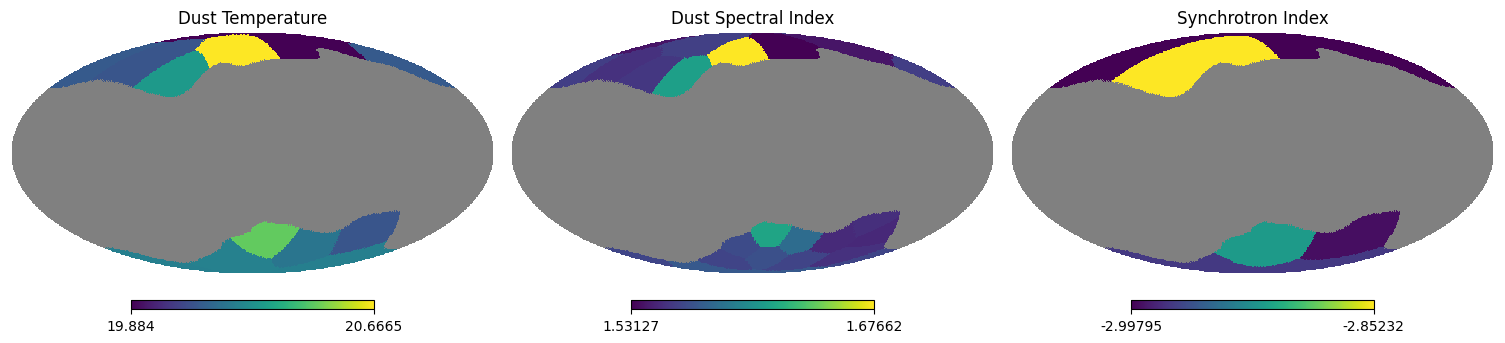

In [ ]:
# Results Visualization
fig = plt.figure(figsize=(15, 5))

# Plot the three parameter maps only
hp.mollview(param_maps["temp_dust"], title="Dust Temperature", sub=(1, 3, 1), bgcolor=(0.0,) * 4)

hp.mollview(param_maps["beta_dust"], title="Dust Spectral Index", sub=(1, 3, 2), bgcolor=(0.0,) * 4)

hp.mollview(param_maps["beta_pl"], title="Synchrotron Index", sub=(1, 3, 3), bgcolor=(0.0,) * 4)

plt.tight_layout()
plt.show()

In [ ]:
perturbations = 1e-5
perturbations = jnp.arange(-5, 5).reshape(-1, 1) * perturbations

final_params_perturbed = jax.tree.map(lambda p: p.reshape(1, -1) + perturbations, final_params)


@jax.jit
def grad_nll(params):
    return jax.grad(negative_log_likelihood_fn)(
        params,
        nu=nu,
        N=N,
        d=masked_d,
        patch_indices=masked_clusters,
    )


@jax.jit
def nll(params):
    return negative_log_likelihood_fn(
        params,
        nu=nu,
        N=N,
        d=masked_d,
        patch_indices=masked_clusters,
    )


nlls = jax.vmap(nll)(final_params_perturbed)
grads = jax.vmap(grad_nll)(final_params_perturbed)
grads_beta_dust = grads["beta_dust"]
grads_beta_pl = grads["beta_pl"]
grads_temp_dust = grads["temp_dust"]

grads_beta_dust_norm = jnp.linalg.norm(grads_beta_dust, axis=1)
grads_beta_pl_norm = jnp.linalg.norm(grads_beta_pl, axis=1)
grads_temp_dust_norm = jnp.linalg.norm(grads_temp_dust, axis=1)

TypeError: JAX does not support string indexing; got idx=('beta_dust',)